In [89]:
import pandas as pandas

In [90]:
# import blocks.csv data
blocks = pandas.read_csv('sf_blocks_2020.csv')

#import districts.csv data
districts = pandas.read_csv('sf_districts_2020.csv')

In [91]:
# https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.2020.html

# only keep columns TRACTCE20, BLOCKCE20, GEOID20, NAME20, and multipolygon
blocks = blocks[['TRACTCE20', 'BLOCKCE20', 'GEOID20', 'multipolygon']]

# rename multipolygon to geometry
blocks = blocks.rename(columns={'multipolygon': 'geometry'})

blocks.head()

,TRACTCE20,BLOCKCE20,GEOID20,geometry
0,30900,7005,60750309007005,"MULTIPOLYGON (((-122.475109 37.725692, -122.47..."
1,35300,2009,60750353002009,"MULTIPOLYGON (((-122.494979 37.742201, -122.49..."
2,23001,3007,60750230013007,"MULTIPOLYGON (((-122.4034 37.730658, -122.4026..."
3,61101,2011,60750611012011,"MULTIPOLYGON (((-122.401853 37.796626, -122.40..."
4,61501,1010,60750615011010,"MULTIPOLYGON (((-122.39868 37.789454, -122.397..."


In [92]:
# only keep sup_dist and multipolygon
districts = districts[['sup_dist', 'multipolygon']]

# rename sup_dist to district and multipolygon to geometry
districts = districts.rename(columns={'sup_dist': 'district', 'multipolygon': 'geometry'})

districts.head()

,district,geometry
0,3,MULTIPOLYGON (((-122.41972400060102 37.8111349...
1,2,MULTIPOLYGON (((-122.47695199953101 37.8109830...
2,1,MULTIPOLYGON (((-122.48519700041503 37.7901970...
3,5,MULTIPOLYGON (((-122.42705999984237 37.7887869...
4,6,MULTIPOLYGON (((-122.39381899978358 37.7937380...


In [93]:
# extract multipolygon data and visualize it
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# convert multipolygon data to geopandas dataframe
blocks['geometry'] = blocks['geometry'].apply(wkt.loads)
blocks = gpd.GeoDataFrame(blocks, geometry='geometry')

# convert multipolygon data to geopandas dataframe
districts['geometry'] = districts['geometry'].apply(wkt.loads)
districts = gpd.GeoDataFrame(districts, geometry='geometry')

In [94]:
# create a new data set where one column is a block and the other is a list of districts that the block overlaps with geometrically
blocks_districts = gpd.overlay(blocks, districts, how='intersection')

# for each row in blocks_in_districts
for index, row in blocks_districts.iterrows():
    # get block multipolygon
    block_multipolygon = row['geometry']

    # get district
    district = row['district']

    # get district's multipolygon
    district_multipolygon = districts[districts['district'] == district]['geometry'].values[0]

    # determine the percent of the block area that is in the district multipolygon
    percent = block_multipolygon.intersection(district_multipolygon).area / block_multipolygon.area

    # add a new column to blocks_in_districts called percent that contains the percent of the block area that is in the district multipolygon
    blocks_districts.at[index, 'percent'] = percent

    # sort rows by percent from least to greatest
    blocks_districts = blocks_districts.sort_values(by='percent')

In [95]:
# remove blocks where percent < 0.5
blocks_districts = blocks_districts[blocks_districts['percent'] >= 0.5]

(-122.55, -122.35)

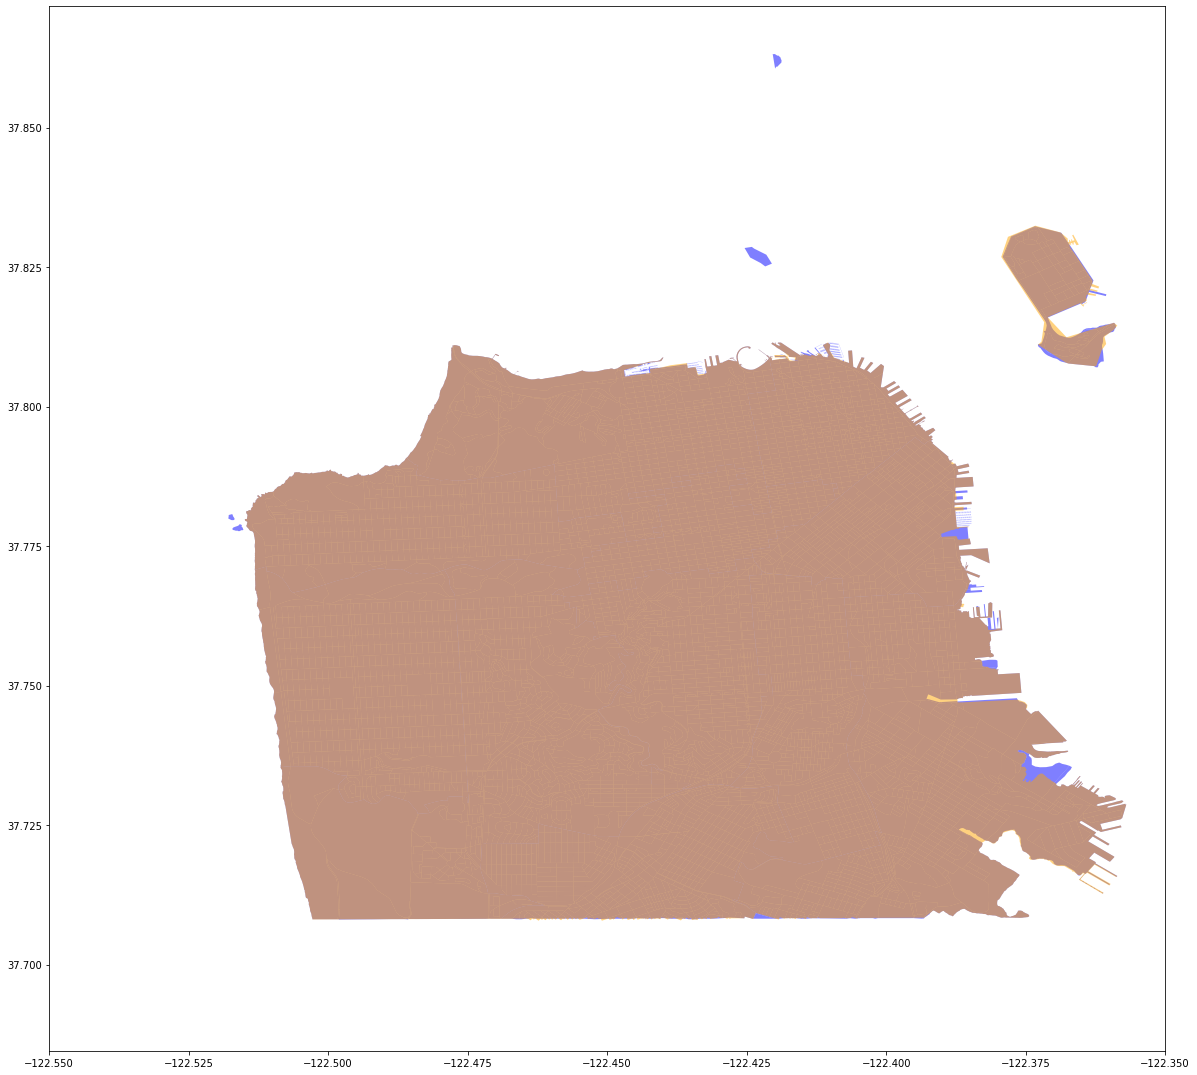

In [96]:
# plot blocks and districts data on the same plot with the districts plot slightly translucent
fig, ax = plt.subplots()
blocks.plot(ax=ax, color='blue', alpha=0.5)
districts.plot(ax=ax, color='orange', alpha=0.5)

# set size bigger
fig.set_size_inches(20, 20)

# limit fig to -122.55 to -122.35
plt.xlim(-122.55, -122.35)

In [97]:
blocks_districts.head()

,TRACTCE20,BLOCKCE20,GEOID20,district,geometry,percent
3345,31301,2006,60750313012006,7,"POLYGON ((-122.47257 37.71921, -122.47260 37.7...",0.524053
4981,61501,1001,60750615011001,3,"MULTIPOLYGON (((-122.39830 37.79175, -122.3983...",0.545205
5731,31201,3002,60750312013002,7,"MULTIPOLYGON (((-122.46210 37.72527, -122.4615...",0.552882
6018,15801,2003,60750158012003,2,"MULTIPOLYGON (((-122.43935 37.78244, -122.4393...",0.692290
5525,30102,2010,60750301022010,7,"MULTIPOLYGON (((-122.44791 37.75759, -122.4481...",0.703100


In [ ]:
# create a df with the district and a list of TRACTCE20s that are in the district
districts_tracts = blocks_districts.groupby('district')['TRACTCE20'].apply(list).reset_index()

# rename TRACTCE20 to tracts
districts_tracts = districts_tracts.rename(columns={'TRACTCE20': 'tracts'})

In [98]:
# calculate how much of each district is composed of blocks with percent column of >0.5
# for row in districts
for i, row in districts.iterrows():
    # get the district's multipolygon
    district_multipolygon = row['geometry']

    district = row['district']

    # get the blocks in blocks_districts that are in the district and have a percent column of >0.5
    blocks_in_district = blocks_districts[(blocks_districts['district'] == district) & (blocks_districts['percent'] > 0.5)]

    # calculate the percent of the district that is composed of these blocks
    percent = blocks_in_district['geometry'].area.sum() / district_multipolygon.area

    # add percent to percent column of row where district is district
    districts_tracts.loc[blocks_districts['district'] == district, 'percent'] = percent

In [99]:
districts_tracts.head()

# to csv
districts_tracts.to_csv('sf_districts_tracts_2020.csv', index=False)